# Chat Intents

## UMAP + Clustering

In [276]:
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

import matplotlib.pyplot as plt

import hdbscan
import umap
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

from tqdm.notebook import tqdm, trange
from functools import partial
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

In [11]:
import tensorflow as tf
import tensorflow_hub as hub

In [12]:
from sentence_transformers import SentenceTransformer

### Load data and pre-trained models

In [16]:
data_sample = pd.read_csv('../data/processed/data_sample.csv')
data_sample.head()

,Unnamed: 0,text,category,cleaned_text
0,1024,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,im worried card might lost mail long usually take arrive
1,9405,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,got charged fee shouldnt cash
2,9368,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,charge making withdrawal took money account earlier charged
3,3414,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,issue account dont see cheque deposit made yesterday please assist
4,7402,Are there ways for other people to send me money?,receiving_money,way people send money


In [32]:
all_intents = list(data_sample['text'])
len(all_intents)

1000

In [14]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_use = hub.load(module_url)

print(f"module {module_url} loaded")

INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 230.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 460.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 690.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 920.00MB
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [263]:
model_st1 = SentenceTransformer('paraphrase-mpnet-base-v2')
model_st2 = SentenceTransformer('paraphrase-distilroberta-base-v2')
model_st3 = SentenceTransformer('stsb-mpnet-base-v2')

Downloading:   0%|          | 0.00/736 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/686 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/868 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.67k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/588 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [272]:
def embed(model, model_type, sentences):
    if model_type == 'use':
        embeddings = model(sentences)
    elif model_type == 'sentence transformer':
        embeddings = model.encode(sentences)
    
    return embeddings

In [268]:
embeddings_use = embed(model_use, 'use', all_intents)
embeddings_use.shape

TensorShape([1000, 512])

In [269]:
embeddings_st1 = embed(model_st1, 'sentence transformer', all_intents)
embeddings_st1.shape

(1000, 768)

In [270]:
embeddings_st2 = embed(model_st2, 'sentence transformer', all_intents)
embeddings_st2.shape

(1000, 768)

In [271]:
embeddings_st3 = embed(model_st3, 'sentence transformer', all_intents)
embeddings_st3.shape

(1000, 768)

### Helper functions

In [277]:
def generate_clusters(message_embeddings, 
                      n_neighbors = 4, 
                      n_components = 5, 
                      min_cluster_size = 4, 
                      random_state = None):
    
    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors, 
                                n_components = n_components, 
                                metric = 'cosine', 
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, 
                              metric='euclidean', 
                              cluster_selection_method='eom').fit(umap_embeddings)
    return clusters

In [287]:
def score_clusters(clusters, prob_threshold = 0.05):
    """
    Returns the label count and cost of a given cluster supplied from running hdbscan
    """
    
    #clusters = generate_clusters(message_embeddings, n_neighbors, n_components, min_cluster_size, random_state)
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(example_clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost

In [142]:
def grid_search(embeddings):
    
    results = []
    for n_neighbors in trange(3, 15, desc='n_neighbors'):
        for n_components in trange (3, 8, desc='n_components'):
            for min_cluster_size in trange(2, 10, desc='min_cluster_size'):
                
                avg_label_count, avg_score = score_clusters(n_repeats, n_neighbors, 
                                                            n_components, min_cluster_size)
                
                results.append([n_neighbors, n_components, min_cluster_size, avg_label_count, avg_score])
    
    result_df = pd.DataFrame(results, columns=['n_neighbors', 'n_components', 'min_cluster_size', 'avg_label_count', 'avg_score'])
    
    return result_df

In [ ]:
%%time
results_use = scan_hyperparameters(all_intents, 3)

In [284]:
len(example_clusters.labels_)

1000

In [35]:
%%time
use_embeddings = embed_use(model_use, all_intents)
score_clusters(3, use_embeddings, n_neighbors=4, n_components=4, min_cluster_size=4)

CPU times: user 19.2 s, sys: 1.22 s, total: 20.5 s
Wall time: 16.2 s


(83.0, 140.33333333333334)

In [145]:
%%time
use_embeddings = embed_use(model_use, all_intents)
score_clusters(3, use_embeddings, n_neighbors=4, n_components=4, min_cluster_size=4)

CPU times: user 15.7 s, sys: 1.73 s, total: 17.4 s
Wall time: 14 s


(80.0, 124.0)

In [146]:
%%time
use_embeddings = embed_use(model_use, all_intents)
score_clusters(1, use_embeddings, n_neighbors=4, n_components=4, min_cluster_size=4, random_state=42)

CPU times: user 4.73 s, sys: 2.82 s, total: 7.54 s
Wall time: 11.8 s


(77.0, 125.0)

In [149]:
%%time
use_embeddings = embed_use(model_use, all_intents)
score_clusters(1, use_embeddings, n_neighbors=4, n_components=4, min_cluster_size=4, random_state=42)

CPU times: user 3.07 s, sys: 101 ms, total: 3.17 s
Wall time: 2.7 s


(77.0, 125.0)

In [84]:
results_use

,n_neighbors,n_components,min_cluster_size,avg_label_count,avg_score
0,3,3,2,179,77.4


In [58]:
results_use[(results_use.score < 100)&(results_use.label_count < 100)&(results_use.label_count > 10)]

,n_neighbors,n_components,min_cluster_size,label_count,score
42,3,3,4,85,92
50,3,4,4,81,98
63,3,5,9,27,72
67,3,6,5,60,77


In [60]:
results_use.head()

,n_neighbors,n_components,min_cluster_size,label_count,score
0,2,3,2,201,97
1,2,3,3,147,152
2,2,3,4,104,247
3,2,3,5,87,226
4,2,3,6,70,230


In [71]:
use_embeddings = embed_use(model_use, all_intents)
num = 5
param_dict = [[4, 5, 4], 
              [3, 5, 9], 
              [3, 3, 4], 
              [3, 4, 4], 
              [3, 6, 6]]

for params in param_dict:
    count_sum = 0
    score_sum = 0
    
    for i in range(num):
        clusters = generate_clusters(use_embeddings, 
                                     n_neighbors = params[0], 
                                     n_components = params[1], 
                                     min_cluster_size = params[2])
        
        label_count, score = score_clusters(clusters)

        count_sum += label_count
        score_sum += score

    print(f"Avg number of clusters: {count_sum/num} . Avg score: {score_sum/num}")

Avg number of clusters: 85.8 . Avg score: 130.2
Avg number of clusters: 31.0 . Avg score: 178.6
Avg number of clusters: 86.6 . Avg score: 97.0
Avg number of clusters: 87.4 . Avg score: 104.2
Avg number of clusters: 53.2 . Avg score: 142.4


In [92]:
use_embeddings = embed_use(model_use, all_intents)
clusters = generate_clusters(use_embeddings, n_neighbors = 3, n_components = 3, min_cluster_size = 4)
label_count, score = score_clusters(clusters)
print(label_count)
print(score)

88
125


In [146]:
intents_df_use = pd.DataFrame(all_intents, columns=['message'])
intents_df_use['topic_use'] = clusters.labels_
intents_df_use.head(10)

,message,topic_use
0,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,64
1,I got charged a fee that shouldn't be there from my cash,79
2,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,86
3,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,67
4,Are there ways for other people to send me money?,13
5,How can I receive money?,13
6,where can I change my address?,21
7,What do I do if I still have not received my new card?,74
8,Is there anywhere I can't use my card?,54
9,I want to have multiple currencies in my account if possible.,42


In [140]:
st1_embeddings = embed_st(model_st1, all_intents)
clusters_st1 = generate_clusters(st1_embeddings, n_neighbors = 3, n_components = 3, min_cluster_size = 4)
label_count_st1, score_st1 = score_clusters(clusters_st1)
print(label_count_st1)
print(score_st1)

93
71


### Bayeisan optimization with Hyperopt

In [288]:
def objective(params, embeddings, random_state):
    
    clusters = generate_clusters(embeddings, 
                                 n_neighbors = params['n_neighbors'], 
                                 n_components = params['n_components'], 
                                 min_cluster_size = params['min_cluster_size'], 
                                 random_state = random_state)
    
    label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
    
    #10% penalty on the cost function if outside the desired range of groups
    if (label_count < 30) | (label_count > 100):
        penalty = 0.1 
    else:
        penalty = 0
    
    loss = cost + penalty
    
    return {'loss': loss, 'label_count': label_count, 'status': STATUS_OK}

In [289]:
def bayesian_search(embeddings, max_evals=100):
    
    space = {
        "n_neighbors": hp.choice('n_neighbors', list(range(3,16))),
        "n_components": hp.choice('n_components', list(range(3,16))),
        "min_cluster_size": hp.choice('min_cluster_size', list(range(2,15)))
    }
    
    trials = Trials()
    fmin_objective = partial(objective, embeddings=embeddings, random_state=42)
    best = fmin(fmin_objective, 
                space = space, 
                algo=tpe.suggest,
                #algo=partial(tpe.suggest, n_startup_jobs=20),#otherwise the first 20 will be random by default
                max_evals=max_evals, 
                trials=trials)

    best_params = space_eval(space, best)
    print ('best:')
    print (best_params)
    print (f"label count: {trials.best_trial['result']['label_count']}")
    
    return best_params, trials

In [293]:
def best_clusters(embeddings, best_params):
    clusters_best = generate_clusters(embeddings, 
                                 n_neighbors = best_params['n_neighbors'], 
                                 n_components = best_params['n_components'], 
                                 min_cluster_size = best_params['min_cluster_size'], 
                                 random_state=42)
    
    return clusters_best

##### Find best params for each model

In [291]:
best_params_use, trials_use = bayesian_search(embeddings_use, max_evals=100)

100%|██████████| 100/100 [05:46<00:00,  3.46s/trial, best loss: 0.086]
best:
{'min_cluster_size': 4, 'n_components': 5, 'n_neighbors': 3}
label count: 79


In [297]:
trials_use.best_trial

{'state': 2,
 'tid': 13,
 'spec': None,
 'result': {'loss': 0.086, 'label_count': 79, 'status': 'ok'},
 'misc': {'tid': 13,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'min_cluster_size': [13],
   'n_components': [13],
   'n_neighbors': [13]},
  'vals': {'min_cluster_size': [2], 'n_components': [2], 'n_neighbors': [0]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2021, 9, 1, 16, 14, 57, 565000),
 'refresh_time': datetime.datetime(2021, 9, 1, 16, 14, 59, 967000)}

In [295]:
best_params_st1, trials_st1 = bayesian_search(embeddings_st1, max_evals=100)

100%|██████████| 100/100 [06:02<00:00,  3.62s/trial, best loss: 0.075]             
best:
{'min_cluster_size': 7, 'n_components': 4, 'n_neighbors': 3}
label count: 54


In [296]:
best_params_st2, trials_st2 = bayesian_search(embeddings_st2, max_evals=100)

100%|██████████| 100/100 [06:12<00:00,  3.73s/trial, best loss: 0.058]
best:
{'min_cluster_size': 8, 'n_components': 10, 'n_neighbors': 3}
label count: 36


In [ ]:
best_params_st3, trials_st3 = bayesian_search(embeddings_st3, max_evals=100)

##### Find clusters using best params for each model

In [298]:
best_clusters_use = best_clusters(embeddings_use, best_params_use)

In [299]:
best_clusters_st1 = best_clusters(embeddings_st1, best_params_st1)

In [300]:
best_clusters_st2 = best_clusters(embeddings_st2, best_params_st2)

In [ ]:
best_clusters_st3 = best_clusters(embeddings_st3, best_params_st3)

In [205]:
st1_embeddings = embed_st(model_st1, all_intents)
st1_best, _ = bayesian_search(st1_embeddings, max_evals=50)

100%|██████████| 50/50 [03:31<00:00,  4.24s/trial, best loss: 77.0]
best:
{'min_cluster_size': 3, 'n_components': 11, 'n_neighbors': 6}
label count: 98.0


In [216]:
use_clusters = generate_clusters(use_embeddings, 
                                 n_neighbors = use_best['n_neighbors'], 
                                 n_components = use_best['n_components'], 
                                 min_cluster_size = use_best['min_cluster_size'], 
                                 random_state=42)

In [209]:
st1_clusters = generate_clusters(st1_embeddings, 
                                 n_neighbors = st1_best['n_neighbors'], 
                                 n_components = st1_best['n_components'], 
                                 min_cluster_size = st1_best['min_cluster_size'], 
                                 random_state=42)

In [215]:
len(np.unique(st1_clusters.labels_))

98

In [166]:
use_embeddings = embed_use(model_use, all_intents)
score_clusters(1, use_embeddings, n_neighbors=3, n_components=4, min_cluster_size=4, random_state=42)

(84.0, 84.0)

In [170]:
use_embeddings = embed_use(model_use, all_intents)
score_clusters(1, use_embeddings, n_neighbors=4, n_components=11, min_cluster_size=4, random_state=42)

(83.0, 106.0)

In [187]:
st1_embeddings = embed_st(model_st1, all_intents)
score_clusters(1, st1_embeddings, n_neighbors=3, n_components=11, min_cluster_size=4, random_state=42)

(92.0, 80.0)

## Evaluate clusters

In [306]:
results_df = pd.DataFrame(all_intents, columns=['message'])
results_df['category'] = data_sample.category

cluster_dict = {'label_use': best_clusters_use, 
                'label_st1': best_clusters_st1, 
                'label_st2': best_clusters_st2} 
                #'label_st3': best_clusters_st3}

for key, value in cluster_dict.items():
    results_df[key] = value.labels_
    
results_df.head()

,message,category,label_use,label_st1,label_st2
0,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,55,35,11
1,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,67,14,26
2,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,74,14,26
3,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,71,45,27
4,Are there ways for other people to send me money?,receiving_money,26,32,26


### Visually inspect clusters

In [241]:
def plot_clusters(embeddings, clusters, n_neighbors=4):
    umap_data = umap.UMAP(n_neighbors=n_neighbors, 
                          n_components=2, 
                          min_dist = 0.0, 
                          metric='cosine', 
                          random_state=42).fit_transform(embeddings)

    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = clusters.labels_

    fig, ax = plt.subplots(figsize=(14, 8))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color = '#BDBDBD', s=4)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=4, cmap='hsv_r')
    plt.colorbar()
    plt.show()

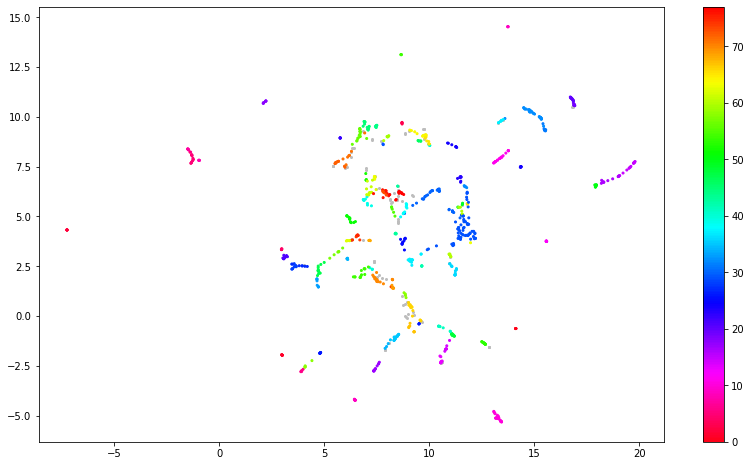

In [242]:
plot_clusters(use_embeddings, use_clusters, n_neighbors=4)

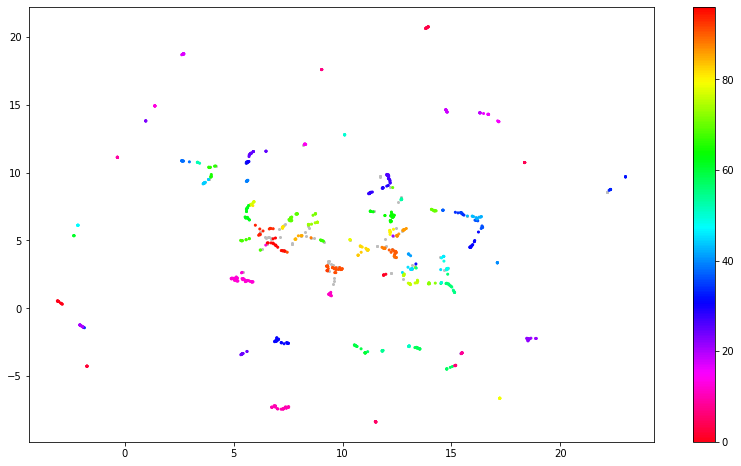

In [243]:
plot_clusters(st1_embeddings, st1_clusters, n_neighbors=4)

### Manually inspect category consistency

In [249]:
results_df[results_df['label_use']==2]

,message,category,label_use,label_st1
44,What are the countries you have offices in?,country_support,2,16
279,What countries are you available in?,country_support,2,16
295,What are the countries that you operate in?,country_support,2,16
503,Which countries do you operate in,country_support,2,16
600,How do I know which countries you provide service in?,country_support,2,16
898,I would like to know the countries you are offer services in?,country_support,2,16


In [245]:
results_df[results_df['category']=='country_support']

,message,category,label_use,label_st1
11,Do you do business in the EU?,country_support,41,15
44,What are the countries you have offices in?,country_support,2,16
122,Can I use this all over the world?,country_support,47,16
279,What countries are you available in?,country_support,2,16
295,What are the countries that you operate in?,country_support,2,16
311,Can I get a card in the EU?,country_support,41,61
503,Which countries do you operate in,country_support,2,16
600,How do I know which countries you provide service in?,country_support,2,16
724,"I'm not in the UK, but can I still get a card?",country_support,41,61
732,Can I get support?,country_support,32,53


Both USE and ST1 models have high precision for `country_support` category but also both miss many instances in that group.

In [250]:
results_df[results_df['category']=='card_about_to_expire']

,message,category,label_use,label_st1
27,"I am overseas in China, can I get a replacement card?",card_about_to_expire,35,25
370,"If I am in China, can I still order a new card and if so, how?",card_about_to_expire,35,25
441,My card is almost expired. How fast will I get a new one and what is the cost?,card_about_to_expire,9,25
477,My card is about to expire. Do I have to go to a branch to order a new card?,card_about_to_expire,9,25
521,"My card expires soon, will you send me one automatically?",card_about_to_expire,9,25
524,My card expires very soon. What is the cost and delivery time to get a new one?,card_about_to_expire,9,25
551,Where can I have a new bank card sent to China?,card_about_to_expire,35,25
584,How do I get a new expiration date?,card_about_to_expire,9,25
605,Are there any express fees if i want my new card faster?,card_about_to_expire,-1,25
646,My card is almost going to expire.,card_about_to_expire,9,25


In [251]:
results_df[results_df['label_st1']==25]

,message,category,label_use,label_st1
27,"I am overseas in China, can I get a replacement card?",card_about_to_expire,35,25
108,I would like to purchase another card.,getting_spare_card,66,25
370,"If I am in China, can I still order a new card and if so, how?",card_about_to_expire,35,25
383,What is the price for an additional card?,getting_spare_card,-1,25
441,My card is almost expired. How fast will I get a new one and what is the cost?,card_about_to_expire,9,25
477,My card is about to expire. Do I have to go to a branch to order a new card?,card_about_to_expire,9,25
521,"My card expires soon, will you send me one automatically?",card_about_to_expire,9,25
524,My card expires very soon. What is the cost and delivery time to get a new one?,card_about_to_expire,9,25
551,Where can I have a new bank card sent to China?,card_about_to_expire,35,25
584,How do I get a new expiration date?,card_about_to_expire,9,25


### Manually inspect category consistency with ground truth labels

In [307]:
def comparison_table(model_dict, results_df):
    summary = []

    for key, value in model_dict.items():
        ari = np.round(adjusted_rand_score(results_df['category'].values, results_df[value].values), 3)
        nmi = np.round(normalized_mutual_info_score(results_df['category'].values, results_df[value].values), 3)
        summary.append([key, ari, nmi])

    comparison_df = pd.DataFrame(results, columns=['Model','ARI', 'NMI'])
    
    return comparison_df

In [311]:
model_dict = {'USE': 'label_use', 
              'Sent-Transformer_1': 'label_st1', 
              'Sent-Transformer_2': 'label_st2'}

comparison_table(model_dict, results_df)

,Model,ARI,NMI
0,USE,0.268,0.725
1,Sent-Transformer_1,0.410,0.798
